In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/MyDrive')

Mounted at /content/gdrive


In [3]:
import networkx as nx
import numpy as np
import random
import pandas as pd
import seaborn as sns
import epi_process as ep
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.animation import FuncAnimation
sns.set()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
class EpiProcess():
    def __init__(self, size, percent, viz=False):
        #вызываем стартовые инциализаторы
        self.paramertrs_init(size, percent, viz)

        self.graph_init()  

        self.random_start_sample()
        
        if self.viz:
            self.viz_init(viz)

    def paramertrs_init(self, size, percent, viz):
        #инициализируем параметры процесса
        self.size = size
        self.percent = percent
        self.cummulitive_sum_I = 0
        self.iterations = []
        self.viz=viz
    def graph_init(self):
        #строим configuration_model
        sequence = nx.random_powerlaw_tree_sequence(self.size, tries=5000000)
        self.G = nx.configuration_model(sequence)

    def viz_init(self,viz):
        #инциализируем необходимое для визуализации распростронения
        self.fig = None
        self.axes = None
        self.pos = nx.spring_layout(self.G)
        self.gif=[]
        self.colors = sns.color_palette("hls", 8)

    def random_start_sample(self):
        #Инициализация множеств индивидуумов, изначальной выборки
        self.start_sample_size = int(self.size/100 * self.percent)
        self.S = set(self.G)
        self.I = set()
        self.R = set()
        self.tmp = set()
        self.result = []

        #Заражаем изначальный процент
        while len(self.I)<self.start_sample_size:
            self.infect(random.randint(0, self.size))
        
    def infect(self, x):
        #Заражаем конкретного индивиидума путём перемещения его из множества
        self.S.discard(x)
        if not x in self.R:
            self.I.add(x)
        
    def recover(self, x):
        #Конкретный индивидуум переболел перемещаем его в множество переболевших
        self.I.discard(x)
        self.R.add(x)

    def infect_neigh(self, x):
        #метод заражения соседей
        for neigh in self.G.neighbors(x):
                self.infect(neigh)
        
    def iterartion(self):
        #метод итерации в графе
        #создаем копию больных что бы ничего не испортить
        self.tmp = self.I.copy()

        #для больных заражаем соседей а сам больной восстанавливается
        for x in self.tmp:
            self.infect_neigh(x)
            self.recover(x)
        
    def run(self):
        if self.viz == True:
            #если включена визуализация
            while len(self.I) != 0:
                #добавляем текущую итерацию в список картинок
                self.gif.append(self.vis_spread_info())

                #добавляем в результирующий список больных на текущий момент
                self.result.append(len(self.I))

                #проводим следующую итерацию
                self.iterartion()

            #повторяем для последней итерации    
            self.result.append(len(self.I))
            self.gif.append(self.vis_spread_info())
        else:
            #если визуализация выключена
            while len(self.I) != 0:
                 #добавляем в результирующий список больных на текущий момент
                self.result.append(len(self.I))

                #проводим следующую итерацию
                self.iterartion() 

            #повторяем для последней итерации      
            self.result.append(len(self.I))
    def viz_run(self):
        #метод визуализации распростронения по количеству больных на момент времени
        #получаем из списка результа данные в нужном формате
        y = pd.Series(self.result, name="count")

        #конвертируем итерации в моменты врмени
        x = pd.Series(range(1,len(self.result)+2), name="iteration")

        return sns.lineplot(x,y)

    def plot_degree_dist(self):
        #лямда перебора количества соседей для каждой вершины
        degrees = [self.G.degree(n) for n in self.G.nodes()]

        sns.displot(degrees)

    def plot_degree_dist_neigh(self):
        #получаем график распредления среднего количества соседей среди сосдеей для каждой вершины графа 
        sns.displot(nx.average_neighbor_degree(self.G))

    def vis_spread_info(self):
        #получаем актуальные цвета вершин на текущую итерацию
        colors = (list([self.colors[0]] * len(self.S)) + 
        list([self.colors[1]] * len(self.I)) + 
        list([self.colors[2]] * len(self.R)))

        #получаем актуальную принадлежность множествам вершин на текущую итерацию
        nodes = (list(self.S) +
                 list(self.I) + 
                 list(self.R))

        return nodes,colors

    def update(self,num):
        #рисуем актуальный граф на итерацию Num

        nx.draw_networkx_nodes(self.G, pos=self.pos, nodelist=self.gif[num][0], node_color=self.gif[num][1])
    def viz_joint(self):
        #получаем данные
        neigh=nx.average_neighbor_degree(self.G)
        degrees = [self.G.degree(n) for n in self.G.nodes()]
        #конвертируем в пандас
        y = pd.Series(neigh, name="avg_neigh_degree")

        x = pd.Series(degrees, name="degrees")

        #рисуем
        sns.jointplot(x,y)

Работа процессов

In [ ]:
my_proc = ep.EpiProcess(1000,1,False)
my_proc.run()
print(my_proc.S)
print(my_proc.I)
print(my_proc.R)
print(len(my_proc.S)+len(my_proc.I)+len(my_proc.R))
print(my_proc.result)

{6, 10, 16, 19, 20, 21, 22, 25, 26, 28, 40, 44, 49, 50, 61, 62, 64, 65, 72, 77, 78, 79, 82, 83, 90, 93, 94, 102, 107, 109, 110, 111, 114, 116, 117, 125, 140, 159, 162, 164, 166, 169, 170, 174, 176, 177, 179, 180, 182, 184, 187, 188, 198, 199, 201, 203, 209, 214, 219, 223, 224, 227, 231, 232, 235, 237, 238, 244, 248, 251, 256, 257, 259, 261, 274, 275, 277, 278, 280, 293, 299, 303, 311, 313, 315, 317, 323, 324, 325, 326, 333, 336, 340, 341, 342, 344, 349, 356, 358, 361, 363, 364, 365, 368, 371, 373, 378, 381, 384, 388, 392, 393, 395, 397, 398, 404, 407, 408, 410, 411, 416, 417, 419, 421, 422, 426, 428, 429, 430, 433, 434, 435, 441, 443, 450, 453, 454, 458, 459, 462, 464, 467, 468, 471, 473, 474, 481, 483, 485, 486, 488, 489, 491, 494, 496, 500, 505, 515, 516, 519, 520, 527, 530, 536, 538, 540, 541, 543, 546, 548, 549, 556, 557, 562, 567, 569, 573, 576, 582, 583, 584, 588, 593, 594, 597, 598, 603, 604, 607, 610, 613, 617, 620, 623, 624, 626, 628, 632, 635, 638, 639, 640, 645, 650, 652, 65

Как распространяется эпидемия во времени


#3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


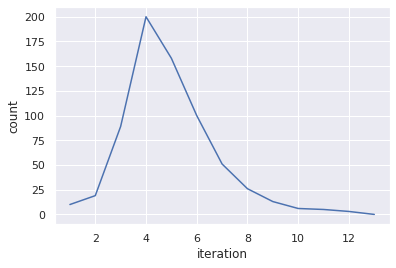

In [ ]:
my_proc.viz_run()

#2 A)

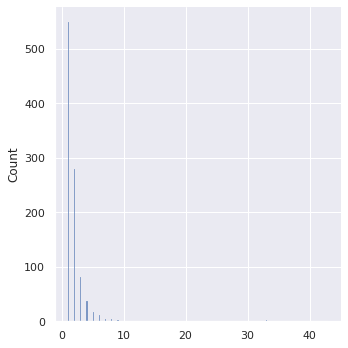

In [ ]:
my_proc.plot_degree_dist()

# 2 B)

Распределение среднего количества соседей для вершин.


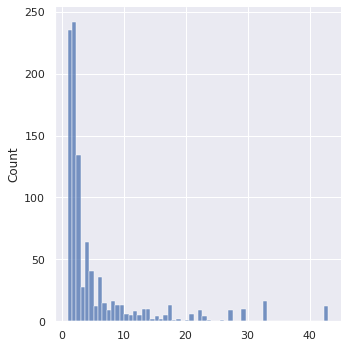

In [ ]:
my_proc.plot_degree_dist_neigh()

Совместное распределение

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


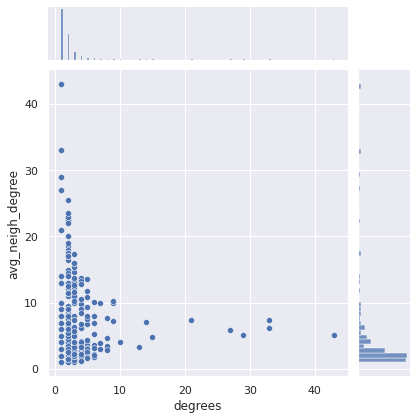

In [ ]:
my_proc.viz_joint()

In [ ]:
fig = plt.gcf()

<Figure size 432x288 with 0 Axes>

# 1) Попытки в анимацию. Не работает :с

In [ ]:
ani = FuncAnimation(fig, my_proc.update,frames=range(len(my_proc.result)), interval=50)

In [ ]:
plt.show()

In [ ]:
ani.save('crap.gif', writer='pillow', fps=1)

IndexError: ignored

In [ ]:
writer = PillowWriter(fps=20)
ani.save("demo2.gif", writer=writer)

In [ ]:
my_proc.update(6)

#4) Много процессов их распределения


In [ ]:
processes=[]
for x in range(0,9):
    processes.append(ep.EpiProcess(1000,1,False))
    processes[x].run()

In [ ]:
for x in processes:
    x.viz_run()

#SIR model


In [113]:
class SIR():
    def __init__(self,size,percent,*args, beta, gamma,**kwargs):
        self.I = int(size/100*percent)
        self.S = size-self.I
        self.R = 0
        self.N = size
        self.beta = beta
        self.gamma = gamma
        self.result_S = []
        self.result_I = []
        self.result_R = []
    def calc(self,times):
        for t in range(0,times):
            ds_dt=self.dS_dt()
            di_dt=self.dI_dt()
            dr_dt=self.dR_dt()
            self.result_S.append(ds_dt )
            self.result_I.append(di_dt )
            self.result_R.append(dr_dt )
            self.S += ds_dt
            self.I += di_dt
            self.R += dr_dt
        print(self.S,self.I,self.R)
    def dS_dt(self):
        return -self.beta * self.S * self.I / self.N
    def dR_dt(self):
        return self.gamma * self.I
    def dI_dt(self):
        return self.beta * self.S * self.I / self.N - self.gamma * self.I
    def viz(self):
        table=list(zip(self.result_S,self.result_I,self.result_R))
        df = pd.DataFrame(table,
               columns =['S', 'I','R'])
       
        return (sns.lineplot(data=df))

15.216357359692 0.3020822244448358 984.4815604158631
[2.96, 3.8156313600000002, 4.904713945148329, 6.281629354172198, 8.007151107729232, 10.144632655856945, 12.7523270472369, 15.870010105684802, 19.49808568876521, 23.568327467947725, 27.90825172894389, 32.20669819366347, 35.99636660433974, 38.6767646596503, 39.60067124859478, 38.228610456682716, 34.31579121149921, 28.052547811854616, 20.07208649645934, 11.296347901211249, 2.6841634402743964, -4.999029348460041, -11.29933391027415, -16.068488917108592, -19.382065780003373, -21.440285227366214, -22.487874104290967, -22.763719149871477, -22.476077240317174, -21.794607578827787, -20.851507221120094, -19.746587981112352, -18.55339554426877, -17.324982522801577, -16.098807455348496, -14.90066286668035, -13.747721767637174, -12.650852737532611, -11.616356802247129, -10.647259851531588, -9.744269056578258, -8.906477783733632, -8.131883318187043, -7.417765688689462, -6.760963574940774, -6.1580740014793305, -5.605595605758609, -5.100030143232006

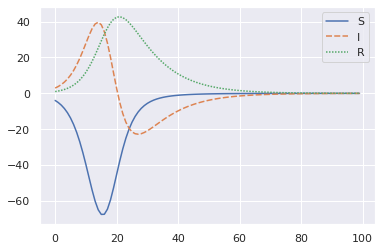

In [114]:
model=SIR(1000,1,beta=0.4,gamma=0.1)
model.calc(100)
print(model.result_I)
model.viz()